# Classification

In [1]:
import pandas as pd
import numpy as np
from itertools import cycle
from scipy import interp
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid", palette="deep")

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score

In [2]:
date_cols = ['issue_d', 'earliest_cr_line']
data = pd.read_csv('data/df_class.csv', parse_dates=date_cols, infer_datetime_format=True)
data = data.reset_index(drop=True)

In [3]:
cat_vars = ['home_owner', 'term', 'employ_length', 'verification_status', 'loan_purpose']
data = pd.get_dummies(data, columns=cat_vars, drop_first=True)

In [4]:
#drop object variables not needed and date variables
data = data.drop(['issue_d', 'earliest_cr_line', 'zip_code', 'addr_state'], axis=1)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441463 entries, 0 to 441462
Data columns (total 29 columns):
Unnamed: 0                             441463 non-null int64
loan_amnt                              441463 non-null float64
annual_inc                             441463 non-null float64
dti                                    441463 non-null float64
delinq_2yrs                            441463 non-null float64
inq_last_6mths                         441463 non-null float64
mths_since_last_delinq                 441463 non-null float64
open_acc                               441463 non-null float64
pub_rec                                441463 non-null float64
revol_bal                              441463 non-null float64
acc_open_past_24mths                   441463 non-null float64
bc_util                                441463 non-null float64
tot_hi_cred_lim                        441463 non-null float64
total_bal_ex_mort                      441463 non-null float64
default  

In [6]:
total = len(data.index)
def_cnt = len(data[data['default'] == 1])

def_pct = def_cnt / (total)

print('Total % of loans that defaulted: ', def_pct)
print("Total % of loans that didn't default: ", 1 - def_pct)

#HEAVILY SKEWED DATASET, accuracy performance metric will NOT work well

Total % of loans that defaulted:  0.7979649483648686
Total % of loans that didn't default:  0.20203505163513136


In [7]:
#create y vector and X matrix
target_col = 'default'

X = data.drop('default', axis=1)
y = data[target_col]

# Split and Scale

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [9]:
cont_vars = ['loan_amnt', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
             'open_acc', 'pub_rec', 'revol_bal', 'credit_life_mths',
             'total_bal_ex_mort', 'tot_hi_cred_lim']

X_train_cont = X_train[cont_vars]
X_test_cont = X_test[cont_vars]

X_train_cat = X_train.drop(cont_vars, axis=1)
X_test_cat = X_test.drop(cont_vars, axis=1)

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#generate the needed scaled sets
mms = MinMaxScaler()
stdsc = StandardScaler()

#create normalized X matrices
X_train_cont_norm = mms.fit_transform(X_train_cont)
X_test_cont_norm = mms.transform(X_test_cont)

#create standardized X matrices
X_train_cont_std = stdsc.fit_transform(X_train_cont)
X_test_cont_std = stdsc.transform(X_test_cont)

In [11]:
X_train_cont_norm = pd.DataFrame(X_train_cont_norm, columns=X_train_cont.columns)
X_test_cont_norm = pd.DataFrame(X_test_cont_norm, columns=X_test_cont.columns)

X_train_cont_std = pd.DataFrame(X_train_cont_std, columns=X_train_cont.columns)
X_test_cont_std = pd.DataFrame(X_test_cont_std, columns=X_test_cont.columns)

In [12]:
#reset index 
X_train_cat = X_train_cat.reset_index(drop=True)
X_test_cat = X_test_cat.reset_index(drop=True)

In [13]:
#concat new scaled matrices
X_train_norm = pd.concat([X_train_cont_norm, X_train_cat], axis=1)
X_test_norm = pd.concat([X_test_cont_norm, X_test_cat], axis=1)

X_train_std = pd.concat([X_train_cont_std, X_train_cat], axis=1)
X_test_std = pd.concat([X_test_cont_std, X_test_cat], axis=1)

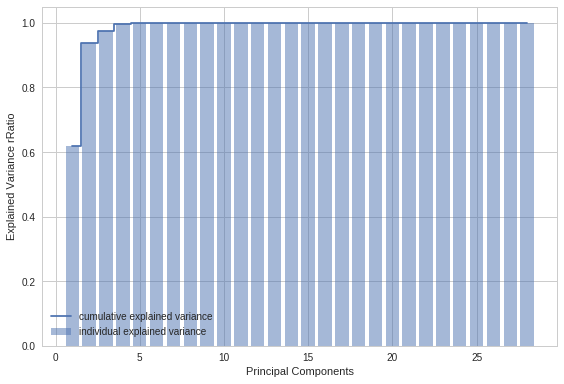

In [140]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(X_train)
exp_var = pca.explained_variance_ratio_
exp_var_sum = np.cumsum(exp_var)

#plot explained variance ratio
plt.bar(range(1, len(exp_var) + 1), exp_var_sum, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, len(exp_var) + 1), exp_var_sum, where='mid', label='cumulative explained variance')
plt.ylabel('Explained Variance rRatio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.tight_layout()
#plt.show()

plt.savefig('figures/PCA.png', bbox_inches='tight', dpi=300)
plt.show()

# Naive Bayes

In [30]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

train_acc = nb.score(X_train, y_train)
test_acc = nb.score(X_test, y_test)

print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)

Train accuracy:  0.797089674627
Test accuracy:  0.79813529529


In [15]:
from sklearn.metrics import precision_score, recall_score, average_precision_score, precision_recall_curve, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict

In [31]:
cv_scores = cross_val_score(nb, X_train, y_train, cv=10, scoring='accuracy')
print(np.mean(cv_scores))

0.797068532072


In [32]:
y_train_pred = cross_val_predict(nb, X_train, y_train, cv=10)

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[  1709,  65252],
       [  1938, 262198]])

In [34]:
precision_score(y_train, y_train_pred)

0.80072682852343868

In [35]:
recall_score(y_train, y_train_pred)

0.99266287064239633

In [47]:
def prec_recal_score(model, f, l):
    cross_val_score(model, f, l, cv=10, scoring = 'accuracy')
    y_train_pred = cross_val_predict(model, f, l, cv=10)
    prec_score = precision_score(l, y_train_pred)
    recal_score = recall_score(l, y_train_pred)    
    
    cm = confusion_matrix(l, y_train_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
        
    print('Model: ', model)
    print('Precision Score: ', prec_score)
    print('Recall Score', recal_score)
    print('Specificity Score: ', TNR, '\n')
    print(classification_report(l, y_train_pred))
    print(confusion_matrix(l, y_train_pred))

In [48]:
nb = GaussianNB()
nb.fit(X_train, y_train)

train_acc = nb.score(X_train, y_train)
test_acc = nb.score(X_test, y_test)

print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)
prec_recal_score(nb, X_train, y_train)

Train accuracy:  0.797089674627
Test accuracy:  0.79813529529
Model:  GaussianNB(priors=None)
Precision Score:  0.800726828523
Recall Score 0.992662870642
Specificity Score:  0.0255223189618 

             precision    recall  f1-score   support

          0       0.47      0.03      0.05     66961
          1       0.80      0.99      0.89    264136

avg / total       0.73      0.80      0.72    331097

[[  1709  65252]
 [  1938 262198]]


No signs of overfitting. 

When model claims loan will not default (TP), it is right 80% of the time. It detects non-default loans 99% of the time. 

# KNN

In [23]:
#knn
from sklearn.neighbors import KNeighborsClassifier

In [24]:
#knn
from sklearn.neighbors import KNeighborsClassifier

#fit KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

train_acc = knn.score(X_train, y_train)
test_acc = knn.score(X_test, y_test)

print('KNN, no scaled features')
print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)
prec_recal_score(knn, X_train, y_train)

KNN, no scaled features
Train accuracy:  0.819379215154
Test accuracy:  0.766975336607
Model:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Precision Score:  0.802867733125
Recall Score 0.935213379994 

             precision    recall  f1-score   support

          0       0.27      0.10      0.14     67061
          1       0.80      0.94      0.86    264036

avg / total       0.70      0.77      0.72    331097

[[  6431  60630]
 [ 17106 246930]]


In [25]:
#knn
from sklearn.neighbors import KNeighborsClassifier

#fit KNN model
knn = KNeighborsClassifier()
knn.fit(X_train_norm, y_train)

train_acc = knn.score(X_train_norm, y_train)
test_acc = knn.score(X_test_norm, y_test)

print('KNN, minmax scaled features')
print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)
prec_recal_score(knn, X_train, y_train)

KNN, minmax scaled features
Train accuracy:  0.815181049662
Test accuracy:  0.764701085479
Model:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Precision Score:  0.802867733125
Recall Score 0.935213379994 

             precision    recall  f1-score   support

          0       0.27      0.10      0.14     67061
          1       0.80      0.94      0.86    264036

avg / total       0.70      0.77      0.72    331097

[[  6431  60630]
 [ 17106 246930]]


In [26]:
#knn
from sklearn.neighbors import KNeighborsClassifier

#fit KNN model
knn = KNeighborsClassifier()
knn.fit(X_train_std, y_train)

train_acc = knn.score(X_train_std, y_train)
test_acc = knn.score(X_test_std, y_test)

print('KNN, standard scaled features')
print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)
prec_recal_score(knn, X_train, y_train)

KNN, standard scaled features
Train accuracy:  0.815446832801
Test accuracy:  0.764556113296
Model:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Precision Score:  0.802867733125
Recall Score 0.935213379994 

             precision    recall  f1-score   support

          0       0.27      0.10      0.14     67061
          1       0.80      0.94      0.86    264036

avg / total       0.70      0.77      0.72    331097

[[  6431  60630]
 [ 17106 246930]]


# Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

train_acc = lr.score(X_train, y_train)
test_acc = lr.score(X_test, y_test)

print('Logistic Regression')
print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)
prec_recal_score(lr, X_train, y_train)

Logistic Regression
Train accuracy:  0.797427944077
Test accuracy:  0.799449105703
Model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Precision Score:  0.797464607503
Recall Score 0.99993561484 

             precision    recall  f1-score   support

          0       0.29      0.00      0.00     67061
          1       0.80      1.00      0.89    264036

avg / total       0.70      0.80      0.71    331097

[[     7  67054]
 [    17 264019]]


# Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier

#make classifier object
dtc = DecisionTreeClassifier(random_state=0)

#fit model
dtc.fit(X_train, y_train)

#report training and test errors
train_acc = dtc.score(X_train, y_train)
test_acc = dtc.score(X_test, y_test)

print('Decision Tree')
print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)
prec_recal_score(dtc, X_train, y_train)

Decision Tree
Train accuracy:  1.0
Test accuracy:  0.701792218618
Model:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
Precision Score:  0.818677815602
Recall Score 0.802439818813 

             precision    recall  f1-score   support

          0       0.28      0.30      0.29     67061
          1       0.82      0.80      0.81    264036

avg / total       0.71      0.70      0.70    331097

[[ 20135  46926]
 [ 52163 211873]]


In [29]:
#print feature importances
pd.DataFrame({'feature': X_train.columns, 'importance': dtc.feature_importances_})

,feature,importance
0,Unnamed: 0,0.090553
1,loan_amnt,0.066435
2,annual_inc,0.067904
3,dti,0.093000
4,delinq_2yrs,0.005895
5,inq_last_6mths,0.016581
6,mths_since_last_delinq,0.038384
7,open_acc,0.047815
8,pub_rec,0.007309
9,revol_bal,0.083217


In [30]:
key_feats = ['loan_amnt', 'annual_inc', 'dti', 'revol_bal', 'credit_life_mths', 'open_acc','default',
             'bc_util', 'tot_hi_cred_lim', 'total_bal_ex_mort']

data_key = data[key_feats]

In [31]:
#create y vector and X matrix from new key features data set
target_col = 'default'

X_key = data_key.drop('default', axis=1)
y_key = data_key[target_col]

In [32]:
from sklearn.model_selection import train_test_split

X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_key, y_key, test_size = 0.25)

In [33]:
#fit model
dtc.fit(X_train_tree, y_train_tree)

#report training and test errors
train_acc = dtc.score(X_train_tree, y_train_tree)
test_acc = dtc.score(X_test_tree, y_test_tree)

print('Decision Tree, no scaled features')
print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)
prec_recal_score(dtc, X_train, y_train)

Decision Tree, no scaled features
Train accuracy:  1.0
Test accuracy:  0.687956435859
Model:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
Precision Score:  0.818677815602
Recall Score 0.802439818813 

             precision    recall  f1-score   support

          0       0.28      0.30      0.29     67061
          1       0.82      0.80      0.81    264036

avg / total       0.71      0.70      0.70    331097

[[ 20135  46926]
 [ 52163 211873]]


# Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
#fit a Random Forest
rf = RandomForestClassifier(random_state=0)

rf.fit(X_train, y_train)

train_acc = rf.score(X_train, y_train)
test_acc = rf.score(X_test, y_test)

print('Random Forest, no feature scaling')
print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)
prec_recal_score(rf, X_train, y_train)

Random Forest, no feature scaling
Train accuracy:  0.99195703978
Test accuracy:  0.777295543918
Model:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
Precision Score:  0.819727868234
Recall Score 0.921347846506 

             precision    recall  f1-score   support

          0       0.40      0.20      0.27     67061
          1       0.82      0.92      0.87    264036

avg / total       0.73      0.78      0.75    331097

[[ 13562  53499]
 [ 20767 243269]]


In [35]:
#print feature importances
pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})

,feature,importance
0,Unnamed: 0,0.082559
1,loan_amnt,0.069424
2,annual_inc,0.071834
3,dti,0.087617
4,delinq_2yrs,0.007579
5,inq_last_6mths,0.018405
6,mths_since_last_delinq,0.040610
7,open_acc,0.053245
8,pub_rec,0.008420
9,revol_bal,0.081357


In [36]:
#fit a Random Forest with only important features
rf = RandomForestClassifier(random_state=0)

rf.fit(X_train_tree, y_train_tree)

train_acc = rf.score(X_train_tree, y_train_tree)
test_acc = rf.score(X_test_tree, y_test_tree)

print('Random Forest, no feature scaling')
print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)
prec_recal_score(rf, X_train_tree, y_train_tree)

Random Forest, no feature scaling
Train accuracy:  0.991334865613
Test accuracy:  0.767953898846
Model:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
Precision Score:  0.810057371812
Recall Score 0.921340191748 

             precision    recall  f1-score   support

          0       0.20      0.09      0.13     67061
          1       0.80      0.91      0.85    264036

avg / total       0.68      0.74      0.70    331097

[[  6122  60939]
 [ 24479 239557]]


In [37]:
n_vals = np.arange(10, 110, 10)

train_acc = []
test_acc = []

for n in n_vals:
    #make object
    rf = RandomForestClassifier(n_estimators = n, random_state = 0)
    
    #fit the model
    rf.fit(X_train_tree, y_train_tree)
    
    train_acc.append(rf.score(X_train_tree, y_train_tree))
    test_acc.append(rf.score(X_test_tree, y_test_tree))

pd.DataFrame({'n': n_vals, 'train_acc': train_acc, 'test_acc': test_acc})

,n,test_acc,train_acc
0,10,0.767954,0.991335
1,20,0.786773,0.997445
2,30,0.791838,0.999037
3,40,0.794203,0.999559
4,50,0.795480,0.999798
5,60,0.796033,0.999903
6,70,0.796097,0.999940
7,80,0.796251,0.999973
8,90,0.796522,0.999994
9,100,0.796586,1.000000


# Support Vector Machine

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from time import time

start = time()
svm = SVC(kernel = 'linear')
score = cross_val_score(svm, X_train, y_train, cv = 10)
print(score)
print(score.mean())
% time()
#print(% (time() - start)

In [ ]:
svm.fit(X_train, y_train)

train_acc = svm.score(X_train, y_train)
test_acc = svm.score(X_test, y_test)
    
print('SVM')
print('Train Accuracy: ', train_acc)
print('Test Accuracy: ', test_acc)
prec_recal_score(svm, X_train, y_train)

# Compare Models

In [137]:
# Classification models
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Bernoulli Naive Bayes': BernoulliNB()
}

#s = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
cv_score_acc_results = []
names = []
prec_scores = []
recall_scores = []
spec_scores = []

for k, v in models.items():
    cv_scores = cross_val_score(estimator=v,
                       X=X_train,
                       y=y_train,
                       cv=10,
                       n_jobs=1,
                    scoring='accuracy')
    
    y_train_pred = cross_val_predict(v, X_train, y_train, cv=10)
    
    cm = confusion_matrix(y_train, y_train_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    
    p = precision_score(y_train, y_train_pred)
    r = recall_score(y_train, y_train_pred)  
    s = TN/(TN+FP) #specificity score
    
    cv_score_acc_results.append(cv_scores)
    names.append(k)
    prec_scores.append(p)
    recall_scores.append(r)
    spec_scores.append(s)
    
    v.fit(X_train, y_train)
    train_acc = v.score(X_train, y_train)
    test_acc = v.score(X_test, y_test)   

    print(k, v)
    print('Train Accuracy: ', train_acc)
    print('Test Accuracy: ', test_acc)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))
    print('Precision Score: ', p)
    print('Recall Score', r)
    print('Specificity Score: ', s, '\n')
    print(classification_report(y_train, y_train_pred))
    print(confusion_matrix(y_train, y_train_pred))
    print('----------------', '\n')

% time()

k-Nearest Neighbors KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Train Accuracy:  0.819016783601
Test Accuracy:  0.767256220213
CV accuracy: 0.766 +/- 0.001
Precision Score:  0.803255924371
Recall Score 0.935131901748
Specificity Score:  0.0965039351264 

             precision    recall  f1-score   support

          0       0.27      0.10      0.14     66961
          1       0.80      0.94      0.86    264136

avg / total       0.70      0.77      0.72    331097

[[  6462  60499]
 [ 17134 247002]]
---------------- 

Gaussian Naive Bayes GaussianNB(priors=None)
Train Accuracy:  0.797089674627
Test Accuracy:  0.79813529529
CV accuracy: 0.797 +/- 0.001
Precision Score:  0.800726828523
Recall Score 0.992662870642
Specificity Score:  0.0255223189618 

             precision    recall  f1-score   support

          0       0.47      0.03      0.05     66961
          1   

()

In [111]:
# Classification models
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Bernoulli Naive Bayes': BernoulliNB()
}

s = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
cv_score_rec_results = []
names = []
prec_scores = []
recall_scores = []
spec_scores = []

for k, v in models.items():
    cv_scores = cross_val_score(estimator=v,
                       X=X_train,
                       y=y_train,
                       cv=10,
                       n_jobs=1,
                    scoring='recall')
    
    y_train_pred = cross_val_predict(v, X_train, y_train, cv=10)
    
    cm = confusion_matrix(y_train, y_train_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    
    p = precision_score(y_train, y_train_pred)
    r = recall_score(y_train, y_train_pred)  
    s = TN/(TN+FP) #specificity score
    
    cv_score_rec_results.append(cv_scores)
    names.append(k)
    prec_scores.append(p)
    recall_scores.append(r)
    spec_scores.append(s)
    
    v.fit(X_train, y_train)
    train_acc = v.score(X_train, y_train)
    test_acc = v.score(X_test, y_test)   

    print(k, v)
    print('Train Accuracy: ', train_acc)
    print('Test Accuracy: ', test_acc)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))
    print('Precision Score: ', p)
    print('Recall Score', r)
    print('Specificity Score: ', s, '\n')
    print(classification_report(y_train, y_train_pred))
    print(confusion_matrix(y_train, y_train_pred))
    print('----------------', '\n')

% time()

k-Nearest Neighbors KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Train Accuracy:  0.819016783601
Test Accuracy:  0.767256220213
CV accuracy: 0.935 +/- 0.001
Precision Score:  0.803255924371
Recall Score 0.935131901748
Specificity Score:  0.000313615388062 

             precision    recall  f1-score   support

          0       0.27      0.10      0.14     66961
          1       0.80      0.94      0.86    264136

avg / total       0.70      0.77      0.72    331097

[[  6462  60499]
 [ 17134 247002]]
---------------- 

Gaussian Naive Bayes GaussianNB(priors=None)
Train Accuracy:  0.797089674627
Test Accuracy:  0.79813529529
CV accuracy: 0.993 +/- 0.001
Precision Score:  0.800726828523
Recall Score 0.992662870642
Specificity Score:  0.000313615388062 

             precision    recall  f1-score   support

          0       0.47      0.03      0.05     66961
          

()

In [114]:
# Classification models
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Bernoulli Naive Bayes': BernoulliNB()
}

s = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
cv_score_prec_results = []
names = []
prec_scores = []
recall_scores = []
spec_scores = []

for k, v in models.items():
    cv_scores = cross_val_score(estimator=v,
                       X=X_train,
                       y=y_train,
                       cv=10,
                       n_jobs=1,
                    scoring='precision')
    
    y_train_pred = cross_val_predict(v, X_train, y_train, cv=10)
    
    cm = confusion_matrix(y_train, y_train_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    
    p = precision_score(y_train, y_train_pred)
    r = recall_score(y_train, y_train_pred)  
    s = TN/(TN+FP) #specificity score
    
    cv_score_prec_results.append(cv_scores)
    names.append(k)
    prec_scores.append(p)
    recall_scores.append(r)
    spec_scores.append(s)
    
    v.fit(X_train, y_train)
    train_acc = v.score(X_train, y_train)
    test_acc = v.score(X_test, y_test)   

    print(k, v)
    print('Train Accuracy: ', train_acc)
    print('Test Accuracy: ', test_acc)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))
    print('Precision Score: ', p)
    print('Recall Score', r)
    print('Specificity Score: ', s, '\n')
    print(classification_report(y_train, y_train_pred))
    print(confusion_matrix(y_train, y_train_pred))
    print('----------------', '\n')

% time()

k-Nearest Neighbors KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Train Accuracy:  0.819016783601
Test Accuracy:  0.767256220213
CV accuracy: 0.803 +/- 0.001
Precision Score:  0.803255924371
Recall Score 0.935131901748
Specificity Score:  0.0965039351264 

             precision    recall  f1-score   support

          0       0.27      0.10      0.14     66961
          1       0.80      0.94      0.86    264136

avg / total       0.70      0.77      0.72    331097

[[  6462  60499]
 [ 17134 247002]]
---------------- 

Gaussian Naive Bayes GaussianNB(priors=None)
Train Accuracy:  0.797089674627
Test Accuracy:  0.79813529529
CV accuracy: 0.801 +/- 0.000
Precision Score:  0.800726828523
Recall Score 0.992662870642
Specificity Score:  0.0255223189618 

             precision    recall  f1-score   support

          0       0.47      0.03      0.05     66961
          1   

()

In [115]:
# Classification models
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Bernoulli Naive Bayes': BernoulliNB()
}

#s = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
cv_score_f1_results = []
names = []
prec_scores = []
recall_scores = []
spec_scores = []

for k, v in models.items():
    cv_scores = cross_val_score(estimator=v,
                       X=X_train,
                       y=y_train,
                       cv=10,
                       n_jobs=1,
                    scoring='f1')
    
    y_train_pred = cross_val_predict(v, X_train, y_train, cv=10)
    
    cm = confusion_matrix(y_train, y_train_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    
    p = precision_score(y_train, y_train_pred)
    r = recall_score(y_train, y_train_pred)  
    s = TN/(TN+FP) #specificity score
    
    cv_score_f1_results.append(cv_scores)
    names.append(k)
    prec_scores.append(p)
    recall_scores.append(r)
    spec_scores.append(s)
    
    v.fit(X_train, y_train)
    train_acc = v.score(X_train, y_train)
    test_acc = v.score(X_test, y_test)   

    print(k, v)
    print('Train Accuracy: ', train_acc)
    print('Test Accuracy: ', test_acc)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))
    print('Precision Score: ', p)
    print('Recall Score', r)
    print('Specificity Score: ', s, '\n')
    print(classification_report(y_train, y_train_pred))
    print(confusion_matrix(y_train, y_train_pred))
    print('----------------', '\n')

% time()

k-Nearest Neighbors KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Train Accuracy:  0.819016783601
Test Accuracy:  0.767256220213
CV accuracy: 0.864 +/- 0.001
Precision Score:  0.803255924371
Recall Score 0.935131901748
Specificity Score:  0.0965039351264 

             precision    recall  f1-score   support

          0       0.27      0.10      0.14     66961
          1       0.80      0.94      0.86    264136

avg / total       0.70      0.77      0.72    331097

[[  6462  60499]
 [ 17134 247002]]
---------------- 

Gaussian Naive Bayes GaussianNB(priors=None)
Train Accuracy:  0.797089674627
Test Accuracy:  0.79813529529
CV accuracy: 0.886 +/- 0.000
Precision Score:  0.800726828523
Recall Score 0.992662870642
Specificity Score:  0.0255223189618 

             precision    recall  f1-score   support

          0       0.47      0.03      0.05     66961
          1   

()

In [116]:
# Classification models
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Bernoulli Naive Bayes': BernoulliNB()
}

#s = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
cv_score_roc_results = []
names = []
prec_scores = []
recall_scores = []
spec_scores = []

for k, v in models.items():
    cv_scores = cross_val_score(estimator=v,
                       X=X_train,
                       y=y_train,
                       cv=10,
                       n_jobs=1,
                    scoring='roc_auc')
    
    y_train_pred = cross_val_predict(v, X_train, y_train, cv=10)
    
    cm = confusion_matrix(y_train, y_train_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    
    p = precision_score(y_train, y_train_pred)
    r = recall_score(y_train, y_train_pred)  
    s = TN/(TN+FP) #specificity score
    
    cv_score_roc_results.append(cv_scores)
    names.append(k)
    prec_scores.append(p)
    recall_scores.append(r)
    spec_scores.append(s)
    
    v.fit(X_train, y_train)
    train_acc = v.score(X_train, y_train)
    test_acc = v.score(X_test, y_test)   

    print(k, v)
    print('Train Accuracy: ', train_acc)
    print('Test Accuracy: ', test_acc)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))
    print('Precision Score: ', p)
    print('Recall Score', r)
    print('Specificity Score: ', s, '\n')
    print(classification_report(y_train, y_train_pred))
    print(confusion_matrix(y_train, y_train_pred))
    print('----------------', '\n')

% time()

k-Nearest Neighbors KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Train Accuracy:  0.819016783601
Test Accuracy:  0.767256220213
CV accuracy: 0.549 +/- 0.003
Precision Score:  0.803255924371
Recall Score 0.935131901748
Specificity Score:  0.0965039351264 

             precision    recall  f1-score   support

          0       0.27      0.10      0.14     66961
          1       0.80      0.94      0.86    264136

avg / total       0.70      0.77      0.72    331097

[[  6462  60499]
 [ 17134 247002]]
---------------- 

Gaussian Naive Bayes GaussianNB(priors=None)
Train Accuracy:  0.797089674627
Test Accuracy:  0.79813529529
CV accuracy: 0.638 +/- 0.002
Precision Score:  0.800726828523
Recall Score 0.992662870642
Specificity Score:  0.0255223189618 

             precision    recall  f1-score   support

          0       0.47      0.03      0.05     66961
          1   

()

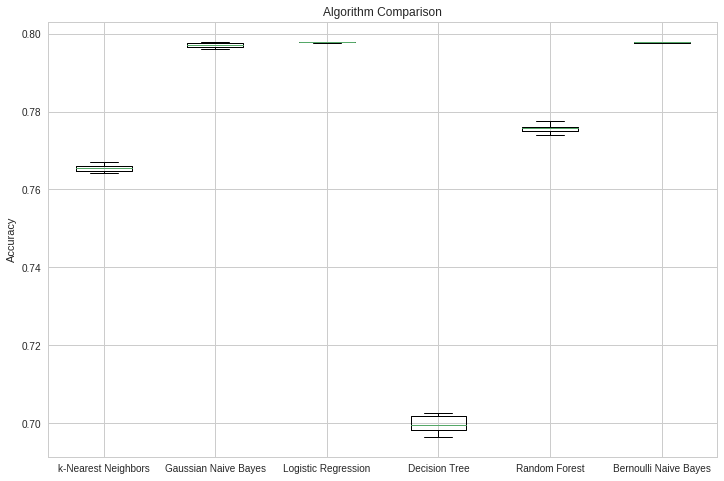

In [138]:
# Compare Algorithms
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.boxplot(cv_score_acc_results)
ax.set_xticklabels(names)
plt.title('Algorithm Comparison')
plt.ylabel('Accuracy')

plt.tight_layout
plt.savefig('figures/AlgCompare.png', bbox_inches='tight', dpi=300)
plt.show()

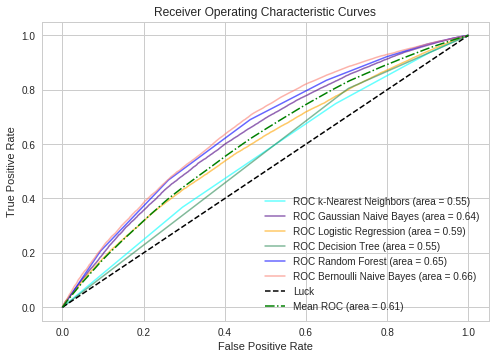

In [139]:
# Run classifiers and plot ROC curves
cv = StratifiedKFold(n_splits=10)
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Bernoulli Naive Bayes': BernoulliNB()
}

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'orange', 'seagreen', 'blue', 'salmon', 'darkorange'])
lw=1.5  #line width
i = 0
for (name, model), color in zip(models.items(), colors):
    probas_ = model.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color, alpha=0.6,
             label='ROC %s (area = %0.2f)' % (name, roc_auc))

    i += 1
        
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= i
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='-.',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend(loc="lower right")

plt.tight_layout
plt.savefig('figures/ROC.png', bbox_inches='tight', dpi=300)

plt.show()

# Tune Final Model(s)

In [119]:
dtc = DecisionTreeClassifier()

param_grid = {'min_samples_split' : range(10,100,10),'max_depth': range(1,10,2), 'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2']}

grid_search = GridSearchCV(dtc, param_grid, cv=10, scoring='accuracy')

start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
print('best params: ', grid_search.best_params_)
print('best estimator: ', grid_search.best_estimator_)

GridSearchCV took 841.68 seconds for 180 candidate parameter settings.
best params:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 20}
best estimator:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [122]:
# Classification models
models = {
    'Decision Tree_tuned': DecisionTreeClassifier(criterion = 'gini', max_depth = 7, 
                                            max_features = 'sqrt', min_samples_split = 20),
    'Decision Tree_plain': DecisionTreeClassifier()
}

dtc_cv_score_acc_results = []
names = []
prec_scores = []
recall_scores = []
spec_scores = []

for k, v in models.items():
    cv_scores = cross_val_score(estimator=v,
                       X=X_train,
                       y=y_train,
                       cv=10,
                       n_jobs=1,
                    scoring='accuracy')
    
    y_train_pred = cross_val_predict(v, X_train, y_train, cv=10)
    
    cm = confusion_matrix(y_train, y_train_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    
    p = precision_score(y_train, y_train_pred)
    r = recall_score(y_train, y_train_pred)  
    s = TN/(TN+FP) #specificity score
    
    dtc_cv_score_acc_results.append(cv_scores)
    names.append(k)
    prec_scores.append(p)
    recall_scores.append(r)
    spec_scores.append(s)
    
    v.fit(X_train, y_train)
    train_acc = v.score(X_train, y_train)
    test_acc = v.score(X_test, y_test)   

    print(k, v)
    print('Train Accuracy: ', train_acc)
    print('Test Accuracy: ', test_acc)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))
    print('Precision Score: ', p)
    print('Recall Score', r)
    print('Specificity Score: ', s, '\n')
    print(classification_report(y_train, y_train_pred))
    print(confusion_matrix(y_train, y_train_pred))
    print('----------------', '\n')

% time()

Decision Tree_tuned DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Train Accuracy:  0.798004814299
Test Accuracy:  0.798244024428
CV accuracy: 0.798 +/- 0.001
Precision Score:  0.802383441611
Recall Score 0.990819123482
Specificity Score:  0.0374098355759 

             precision    recall  f1-score   support

          0       0.51      0.04      0.07     66961
          1       0.80      0.99      0.89    264136

avg / total       0.74      0.80      0.72    331097

[[  2505  64456]
 [  2425 261711]]
---------------- 

Decision Tree_plain DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
  

()

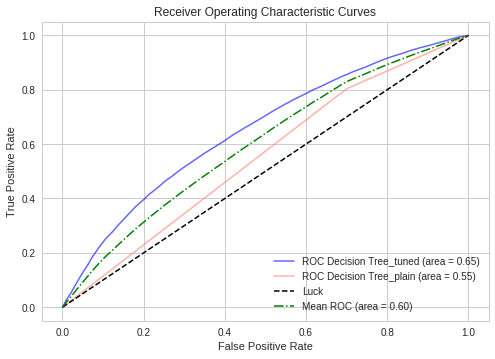

In [141]:
# Run classifiers and plot ROC curves
cv = StratifiedKFold(n_splits=10)
models = {
    'Decision Tree_tuned': DecisionTreeClassifier(criterion = 'gini', max_depth = 7, 
                                            max_features = 'sqrt', min_samples_split = 20),
    'Decision Tree_plain': DecisionTreeClassifier()
}

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['blue', 'salmon'])
lw=1.5  #line width
i = 0
for (name, model), color in zip(models.items(), colors):
    probas_ = model.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color, alpha=0.6,
             label='ROC %s (area = %0.2f)' % (name, roc_auc))

    i += 1
        
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= i
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='-.',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend(loc="lower right")


plt.tight_layout
plt.savefig('figures/ROC_2.png', bbox_inches='tight', dpi=300)
plt.show()

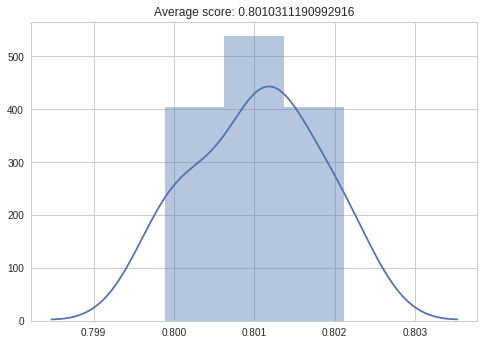

In [90]:
import seaborn as sns
# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(LogisticRegression(C = 0.01, penalty = 'l1'), X_train, y_train, cv=10)
sns.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [125]:
# Use the learning curve to check for overfitting
from sklearn.model_selection import learning_curve, validation_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=DecisionTreeClassifier(),
                                                        X=X_train,
                                                        y=y_train,
                                                        cv=10,
                                                        n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

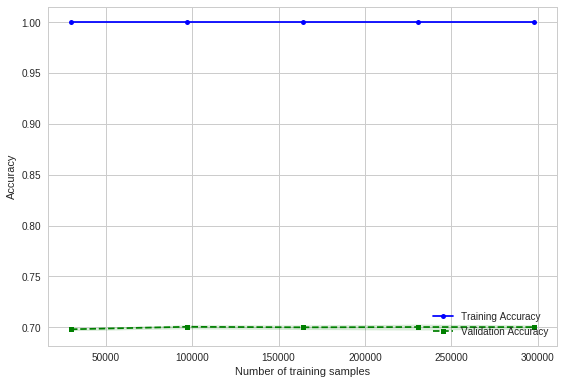

In [126]:
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training Accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation Accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid(True)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
#plt.ylim([0.812, 0.824])
plt.tight_layout()
# plt.savefig('../reports/figures/images/learning_curve.png', dpi=300)
plt.show()

[[ 19918  47043]
 [ 52321 211815]]


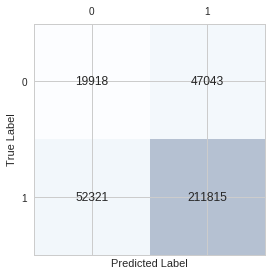

In [130]:
cv_scores = cross_val_score(estimator = DecisionTreeClassifier(),
                       X=X_train,
                       y=y_train,
                       cv=10,
                       n_jobs=1,
                    scoring='accuracy')
    
y_train_pred = cross_val_predict(DecisionTreeClassifier(), X_train, y_train, cv=10)

confmat = confusion_matrix(y_train, y_train_pred)
print(confmat)

# Pretty confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.savefig('figures/conf_matrix_dtc.png')
plt.show()